***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
     </ol>
     <br>

In [2]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression(random_state=0)
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    roc_auc =auc(fpr, tpr)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

### HTML Read Data

In [5]:
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

#### Dropping constants

col_no_unique=[]
for col in df_html.columns[:-1]:
    if len(df_html[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df_html.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_html.shape)

#### 95% same values

lst=[]
for col in df_html.columns[:-1]:
    lst.append([col,dict(df_html[col].value_counts()),df_html[col].value_counts().values[0]>=len(df_html)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

df_html.drop(col_values[col_values['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_html.shape)

#### Dropping columns based on high VIF values

rem=['a_href_absolute','a_href_relative','a_count','a_href_out_of_domain',
     'base_count','base_href_absolute','base_href_out_of_domain',
     'iframe_src_absolute','iframe_src_relative','iframe_sandbox_allow_same_origin_count','iframe_src_http',
     'img_src_absolute','img_src_http','img_srcset_absolute','img_src_relative','img_srcset_relative','img_count',
     'script_src_absolute','script_src_http','script_src_relative','script_count','script_src_https',
     'link_rel_wlwmanifest','link_href_absolute','link_href_relative','link_rel_EditURI','link_count',
     'link_type_application/wlwmanifest+xml','link_href_https','link_rel_stylesheet','link_href_.png',
     'form_action_absolute','form_action_relative','form_count','form_action_https',
     'form_enctype_application/x-www-form-urlencoded',
     'tbody_count',
     'nofollow_count']

print('{} columns are dropped because of high VIF values'.format(len(rem)))
df_html.drop(rem,axis=1,inplace=True)
print("Shape of our dataset after dropping them:",df_html.shape)

Shape of HTML dataset: (43491, 1461)
0 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43491, 1461)
1297 columns have more than 95% same values
Shape of our dataset after dropping them: (43491, 164)
38 columns are dropped because of high VIF values
Shape of our dataset after dropping them: (43491, 126)


### JavaScript read data

In [6]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)

df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)

#### Dropping constants

col_no_unique=[]
for col in df_js.columns[:-1]:
    if len(df_js[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df_js.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_js.shape)

#### 95% same values

lst=[]
for col in df_js.columns[:-1]:
    lst.append([col,dict(df_js[col].value_counts()),df_js[col].value_counts().values[0]>=len(df_js)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst


print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

df_js.drop(col_values[col_values['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_js.shape)


#### Dropping columns based on high VIF values

rem=['js_function_.defineProperty(','js_function_.keys(','js_function_.substr','js_function_unescape(','js_function_.log(']

print('{} columns are dropped because of high VIF values'.format(len(rem)))
df_js.drop(rem,axis=1,inplace=True)
print("Shape of our dataset after dropping them:",df_js.shape)

113 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43294, 288)
234 columns have more than 95% same values
Shape of our dataset after dropping them: (43294, 54)
5 columns are dropped because of high VIF values
Shape of our dataset after dropping them: (43294, 49)


In [7]:
df=pd.concat([df_js,df_html],axis=1,join='inner')
df['Target_z']=df[['Target','Target']].apply(max,axis=1)
df.drop(['Target','Target'],axis=1,inplace=True)
df.rename(columns={'Target_z':'Target'},inplace=True)

In [8]:
df_sel=df.copy(deep=True)

In [11]:
X=df_sel.iloc[:,df_sel.columns!='Target']
Y=df_sel.Target

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

model = XGBClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
thresholds = np.sort(model.feature_importances_)

# for thresh in thresholds:
#     selection = SelectFromModel(model, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(X_train)
#     selection_model = XGBClassifier(random_state=0)
#     selection_model.fit(select_X_train, y_train)
#     select_X_test = selection.transform(X_test)
#     y_pred = selection_model.predict(select_X_test)
#     predictions = [round(value) for value in y_pred]
#     accuracy = accuracy_score(y_test, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 90.50%


In [12]:
# select features using threshold
selection = SelectFromModel(model, threshold=0.010, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier(random_state=0)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

selection_model = selection.get_support()
embeded_rf_feature = X.loc[:,selection_model].columns.tolist()

In [13]:
embeded_rf_feature.append('Target')
embeded_rf_feature

['dom_function_document.getElementById(',
 'dom_function_window.addEventListener(',
 'js_function_.find(',
 'js_function_.get(',
 'js_function_.indexOf(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_escape(',
 'a_href_.com',
 'a_href_http',
 'a_href_https',
 'br_count',
 'center_count',
 'div_count',
 'form_action_http',
 'img_src_.jpg',
 'img_src_out_of_domain',
 'li_count',
 'link_href_.css',
 'link_href_http',
 'link_href_out_of_domain',
 'link_rel_https://api.w.org/',
 'link_rel_shortlink',
 'link_type_application/rsd+xml',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'script_src_.js',
 'script_src_out_of_domain',
 'section_count',
 'span_count',
 'strong_count',
 'title_count',
 'Target']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [14]:
fin_col=embeded_rf_feature

In [15]:
df_sel=df_sel[fin_col]

In [16]:
df_sel.shape[0]*0.8

32567.2

In [17]:
train=df_sel.iloc[:32567,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel[fin_col].iloc[32567:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [18]:
columns=fin_col
columns.remove('Target')

In [19]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9131022200386895
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25466  2372    27838
True         458  4271     4729
__all__    25924  6643    32567

Accuracy of the model for test data is: 0.9046917219356424
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6304   636     6940
True         140  1062     1202
__all__     6444  1698     8142



Logistic Regression
Accuracy of the model for training data is: 0.8938803082875303
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25421  2417    27838
True        1039  3690     4729
__all__    26460  6107    32567

Accuracy of the model for test data is: 0.8951117661508229
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6341   599     6940
True         255   947     1202
__all__     6596  1546     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9248932968956306
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25559  2279    27838
True         167  4562     4729
__all__    25726  6841    32567

Accuracy of the model for test data is: 0.9114468189633996
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6350   590     6940
True         131  1071     1202
__all__     6481  1661     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.9006970245954494
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25392  2446    27838
True         788  3941     4729
__all__    26180  6387    32567

Accuracy of the model for test data is: 0.9006386637189879
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6325   615     6940
True         194  1008     1202
__all__     6519  1623     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9087726840052814
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25514  2324    27838
True         647  4082     4729
__all__    26161  6406    32567

Accuracy of the model for test data is: 0.9057971014492754
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6346   594     6940
True         173  1029     1202
__all__     6519  1623     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9267663585838425
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25571  2267    27838
True         118  4611     4729
__all__    25689  6878    32567

Accuracy of the model for test data is: 0.9119380987472365
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6356   584     6940
True         133  1069     1202
__all__     6489  1653     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9246783553904259
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25560  2278    27838
True         175  4554     4729
__all__    25735  6832    32567

Accuracy of the model for test data is: 0.9107098992876443
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6339   601     6940
True         126  1076     1202
__all__     6465  1677     8142



Neural Network-1
The accuracy of the model on training data is: 0.9136549267681888


Predicted  False  True  __all__
Actual                         
False      25504  2334    27838
True         478  4251     4729
__all__    25982  6585    32567

The accuracy of the model on test data is: 0.9042004421518055


Predicted  False  True  __all__
Actual                         
False       6327   613     6940
True         167  1035     1202
__all__     6494  1648     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [20]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [21]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.913102,4271.0,25466.0,2372.0,458.0,0.085207,0.096849
LogisticRegression,0.893880,3690.0,25421.0,2417.0,1039.0,0.086824,0.219708
RandomForestClassifier,0.924893,4562.0,25559.0,2279.0,167.0,0.081867,0.035314
AdaBoostClassifier,0.900697,3941.0,25392.0,2446.0,788.0,0.087866,0.166631
GradientBoostingClassifier,0.908773,4082.0,25514.0,2324.0,647.0,0.083483,0.136815
ExtraTreeClassifier,0.926766,4611.0,25571.0,2267.0,118.0,0.081435,0.024952
BaggingClassifier,0.924678,4554.0,25560.0,2278.0,175.0,0.081831,0.037006
Neural Network-1,0.913655,4251.0,25504.0,2334.0,478.0,0.083842,0.101078


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.904692,1062.0,6304.0,636.0,140.0,0.091643,0.116473,0.895942,0.691429
LogisticRegression,0.895112,947.0,6341.0,599.0,255.0,0.086311,0.212146,0.850771,0.634513
RandomForestClassifier,0.911447,1071.0,6350.0,590.0,131.0,0.085014,0.108985,0.903000,0.709515
AdaBoostClassifier,0.900639,1008.0,6325.0,615.0,194.0,0.088617,0.161398,0.874993,0.665940
GradientBoostingClassifier,0.905797,1029.0,6346.0,594.0,173.0,0.085591,0.143927,0.885241,0.684140
ExtraTreeClassifier,0.911938,1069.0,6356.0,584.0,133.0,0.084150,0.110649,0.902601,0.710086
BaggingClassifier,0.910710,1076.0,6339.0,601.0,126.0,0.086599,0.104825,0.904288,0.709254
Neural Network-1,0.904200,1035.0,6327.0,613.0,167.0,0.088329,0.138935,0.886368,0.682226


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [22]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [23]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

In [24]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9352862993031108
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24804   3034    27838
True         569  27269    27838
__all__    25373  30303    55676

Accuracy of the model for test data is: 0.8812331122574306
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6067   873     6940
True          94  1108     1202
__all__     6161  1981     8142



Logistic Regression
Accuracy of the model for training data is: 0.8928802356491127
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23118   4720    27838
True        1244  26594    27838
__all__    24362  31314    55676

Accuracy of the model for test data is: 0.8521247850650946
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5800  1140     6940
True          64  1138     1202
__all__     5864  2278     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9522415403405418
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25489   2349    27838
True         310  27528    27838
__all__    25799  29877    55676

Accuracy of the model for test data is: 0.9107098992876443
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6329   611     6940
True         116  1086     1202
__all__     6445  1697     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.9091349953301243
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23928   3910    27838
True        1149  26689    27838
__all__    25077  30599    55676

Accuracy of the model for test data is: 0.8731269958241218
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5985   955     6940
True          78  1124     1202
__all__     6063  2079     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.923342194123141
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24439   3399    27838
True         869  26969    27838
__all__    25308  30368    55676

Accuracy of the model for test data is: 0.8890935887988209
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6128   812     6940
True          91  1111     1202
__all__     6219  1923     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9529060995761189
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25496   2342    27838
True         280  27558    27838
__all__    25776  29900    55676

Accuracy of the model for test data is: 0.9093588798820929
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6319   621     6940
True         117  1085     1202
__all__     6436  1706     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9521517350384366
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25487   2351    27838
True         313  27525    27838
__all__    25800  29876    55676

Accuracy of the model for test data is: 0.9093588798820929
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6314   626     6940
True         112  1090     1202
__all__     6426  1716     8142



Neural Network-1
The accuracy of the model on training data is: 0.9375853150369998


Predicted  False   True  __all__
Actual                          
False      24598   3240    27838
True         235  27603    27838
__all__    24833  30843    55676

The accuracy of the model on test data is: 0.8862687300417588


Predicted  False  True  __all__
Actual                         
False       6088   852     6940
True          74  1128     1202
__all__     6162  1980     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.935286,27269.0,24804.0,3034.0,569.0,0.108988,0.020440
LogisticRegression,0.892880,26594.0,23118.0,4720.0,1244.0,0.169552,0.044687
RandomForestClassifier,0.952242,27528.0,25489.0,2349.0,310.0,0.084381,0.011136
AdaBoostClassifier,0.909135,26689.0,23928.0,3910.0,1149.0,0.140455,0.041275
GradientBoostingClassifier,0.923342,26969.0,24439.0,3399.0,869.0,0.122099,0.031216
ExtraTreeClassifier,0.952906,27558.0,25496.0,2342.0,280.0,0.084130,0.010058
BaggingClassifier,0.952152,27525.0,25487.0,2351.0,313.0,0.084453,0.011244
Neural Network-1,0.937585,27603.0,24598.0,3240.0,235.0,0.116388,0.008442


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.881233,1108.0,6067.0,873.0,94.0,0.125793,0.078203,0.898002,0.658081
LogisticRegression,0.852125,1138.0,5800.0,1140.0,64.0,0.164265,0.053245,0.891245,0.618354
RandomForestClassifier,0.910710,1086.0,6329.0,611.0,116.0,0.088040,0.096506,0.907727,0.712162
AdaBoostClassifier,0.873127,1124.0,5985.0,955.0,78.0,0.137608,0.064892,0.898750,0.648771
GradientBoostingClassifier,0.889094,1111.0,6128.0,812.0,91.0,0.117003,0.075707,0.903645,0.674235
ExtraTreeClassifier,0.909359,1085.0,6319.0,621.0,117.0,0.089481,0.097338,0.906590,0.708797
BaggingClassifier,0.909359,1090.0,6314.0,626.0,112.0,0.090202,0.093178,0.908310,0.710269
Neural Network-1,0.886269,1128.0,6088.0,852.0,74.0,0.122767,0.061564,0.907835,0.674455


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [27]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [28]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

Shape after undersampling (9458, 34)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.5568830619581306
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4589   140     4729
True        4051   678     4729
__all__     8640   818     9458

Accuracy of the model for test data is: 0.8338246131171703
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6636   304     6940
True        1049   153     1202
__all__     7685   457     8142



Logistic Regression
Accuracy of the model for training data is: 0.8839078029181645
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3831   898     4729
True         200  4529     4729
__all__     4031  5427     9458

Accuracy of the model for test data is: 0.8360353721444362
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5662  1278     6940
True          57  1145     1202
__all__     5719  2423     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.947980545569888
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4327   402     4729
True          90  4639     4729
__all__     4417  5041     9458

Accuracy of the model for test data is: 0.9007614836649472
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6232   708     6940
True         100  1102     1202
__all__     6332  1810     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.8942694015648128
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3986   743     4729
True         257  4472     4729
__all__     4243  5215     9458

Accuracy of the model for test data is: 0.8599852616064849
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5874  1066     6940
True          74  1128     1202
__all__     5948  2194     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9109748361175725
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4108   621     4729
True         221  4508     4729
__all__     4329  5129     9458

Accuracy of the model for test data is: 0.8801277327437976
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6035   905     6940
True          71  1131     1202
__all__     6106  2036     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9519983083104251
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4334   395     4729
True          59  4670     4729
__all__     4393  5065     9458

Accuracy of the model for test data is: 0.9027266028002948
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6247   693     6940
True          99  1103     1202
__all__     6346  1796     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9481920067667583
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4322   407     4729
True          83  4646     4729
__all__     4405  5053     9458

Accuracy of the model for test data is: 0.8953574060427414
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6172   768     6940
True          84  1118     1202
__all__     6256  1886     8142



Neural Network-1
The accuracy of the model on training data is: 0.921442165362656


Predicted  False  True  __all__
Actual                         
False       4016   713     4729
True          30  4699     4729
__all__     4046  5412     9458

The accuracy of the model on test data is: 0.8484401866863178


Predicted  False  True  __all__
Actual                         
False       5749  1191     6940
True          43  1159     1202
__all__     5792  2350     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [29]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [30]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.556883,678.0,4589.0,140.0,4051.0,0.029605,0.856629
LogisticRegression,0.883908,4529.0,3831.0,898.0,200.0,0.189892,0.042292
RandomForestClassifier,0.947981,4639.0,4327.0,402.0,90.0,0.085007,0.019032
AdaBoostClassifier,0.894269,4472.0,3986.0,743.0,257.0,0.157116,0.054346
GradientBoostingClassifier,0.910975,4508.0,4108.0,621.0,221.0,0.131317,0.046733
ExtraTreeClassifier,0.951998,4670.0,4334.0,395.0,59.0,0.083527,0.012476
BaggingClassifier,0.948192,4646.0,4322.0,407.0,83.0,0.086065,0.017551
Neural Network-1,0.921442,4699.0,4016.0,713.0,30.0,0.150772,0.006344


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.833825,153.0,6636.0,304.0,1049.0,0.043804,0.872712,0.541742,0.128663
LogisticRegression,0.836035,1145.0,5662.0,1278.0,57.0,0.184150,0.047421,0.884215,0.596210
RandomForestClassifier,0.900761,1102.0,6232.0,708.0,100.0,0.102017,0.083195,0.907394,0.695131
AdaBoostClassifier,0.859985,1128.0,5874.0,1066.0,74.0,0.153602,0.061564,0.892417,0.627489
GradientBoostingClassifier,0.880128,1131.0,6035.0,905.0,71.0,0.130403,0.059068,0.905264,0.663946
ExtraTreeClassifier,0.902727,1103.0,6247.0,693.0,99.0,0.099856,0.082363,0.908891,0.699626
BaggingClassifier,0.895357,1118.0,6172.0,768.0,84.0,0.110663,0.069884,0.909727,0.689028
Neural Network-1,0.848440,1159.0,5749.0,1191.0,43.0,0.171614,0.035774,0.896306,0.620504


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [31]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [32]:
df_sel.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df_sel[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2278 features
EntitySet scattered to workers in 4.287 seconds
Elapsed: 00:12 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [33]:
df_sel.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [34]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [35]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)



X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [38]:
# X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
# X.fillna(value=0,inplace=True)
# y=fs.Target.values
# feature_name = X.columns.tolist()

# scaler=StandardScaler()
# scaled_X=scaler.fit_transform(X)

# print("The train/test split ratio is 70:30")
# X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.3)

# X.shape

In [39]:
feature_name=['div_count + li_count',
 'div_count + js_function_.push(',
 'a_href_https + div_count',
 'script_src_out_of_domain / title_count',
 'script_src_out_of_domain',
 'script_src_.js / title_count',
 'script_src_.js / link_href_.css',
 'script_src_.js + script_src_out_of_domain',
 'script_src_.js',
 'script_async_true + title_count',
 'script_async_true + script_src_out_of_domain',
 'link_type_text/css + script_src_.js',
 'link_type_application/rsd+xml + script_src_out_of_domain',
 'link_type_application/rsd+xml + script_src_.js',
 'link_rel_shortlink + script_src_out_of_domain',
 'link_rel_shortlink + script_src_.js',
 'link_rel_https://api.w.org/ + script_src_out_of_domain',
 'link_rel_https://api.w.org/ + script_src_.js',
 'img_src_.jpg + script_async_true',
 'form_action_http + script_src_out_of_domain',
 'form_action_http + script_src_.js',
 'dom_function_window.addEventListener( + script_src_out_of_domain',
 'dom_function_window.addEventListener( + script_src_.js',
 'div_count + title_count',
 'div_count + script_async_true',
 'div_count + p_count',
 'div_count + meta_count',
 'div_count + link_href_out_of_domain',
 'div_count + img_src_out_of_domain',
 'div_count + img_src_.jpg',
 'center_count + script_src_out_of_domain',
 'center_count + script_src_.js',
 'br_count + div_count',
 'a_href_http + div_count']

In [40]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:32567]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[32567:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [44]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])


feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9095096263088402
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25427  2411    27838
True         536  4193     4729
__all__    25963  6604    32567

Accuracy of the model for test data is: 0.9046917219356424
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6318   622     6940
True         154  1048     1202
__all__     6472  1670     8142



Logistic Regression
Accuracy of the model for training data is: 0.8921607762458931
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25345  2493    27838
True        1019  3710     4729
__all__    26364  6203    32567

Accuracy of the model for test data is: 0.8927781871775976
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6316   624     6940
True         249   953     1202
__all__     6565  1577     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9219148217520803
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25478  2360    27838
True         183  4546     4729
__all__    25661  6906    32567

Accuracy of the model for test data is: 0.9086219602063376
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6327   613     6940
True         131  1071     1202
__all__     6458  1684     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.8913931280130193
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25340  2498    27838
True        1039  3690     4729
__all__    26379  6188    32567

Accuracy of the model for test data is: 0.8922869073937607
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6318   622     6940
True         255   947     1202
__all__     6573  1569     8142



GradientBoosting Classifier


distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method

Accuracy of the model for training data is: 0.9064390333773452
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25513  2325    27838
True         722  4007     4729
__all__    26235  6332    32567

Accuracy of the model for test data is: 0.9049373618275608
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6350   590     6940
True         184  1018     1202
__all__     6534  1608     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.923972119016182
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25485  2353    27838
True         123  4606     4729
__all__    25608  6959    32567

Accuracy of the model for test data is: 0.9091132399901743
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6325   615     6940
True         125  1077     1202
__all__     6450  1692     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9218227039641355
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25478  2360    27838
True         186  4543     4729
__all__    25664  6903    32567

Accuracy of the model for test data is: 0.908867600098256
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6322   618     6940
True         124  1078     1202
__all__     6446  1696     8142



Neural Network-1
The accuracy of the model on training data is: 0.8989467866263274


Predicted  False  True  __all__
Actual                         
False      25272  2566    27838
True         725  4004     4729
__all__    25997  6570    32567

The accuracy of the model on test data is: 0.8985507246376812


Predicted  False  True  __all__
Actual                         
False       6299   641     6940
True         185  1017     1202
__all__     6484  1658     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [45]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [46]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.909510,4193.0,25427.0,2411.0,536.0,0.086608,0.113343
LogisticRegression,0.892161,3710.0,25345.0,2493.0,1019.0,0.089554,0.215479
RandomForestClassifier,0.921915,4546.0,25478.0,2360.0,183.0,0.084776,0.038697
AdaBoostClassifier,0.891393,3690.0,25340.0,2498.0,1039.0,0.089733,0.219708
GradientBoostingClassifier,0.906439,4007.0,25513.0,2325.0,722.0,0.083519,0.152675
ExtraTreeClassifier,0.923972,4606.0,25485.0,2353.0,123.0,0.084525,0.026010
BaggingClassifier,0.921823,4543.0,25478.0,2360.0,186.0,0.084776,0.039332
Neural Network-1,0.898947,4004.0,25272.0,2566.0,725.0,0.092176,0.153309


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.904692,1048.0,6318.0,622.0,154.0,0.089625,0.128120,0.891127,0.687231
LogisticRegression,0.892778,953.0,6316.0,624.0,249.0,0.089914,0.207155,0.851466,0.630975
RandomForestClassifier,0.908622,1071.0,6327.0,613.0,131.0,0.088329,0.108985,0.901343,0.703004
AdaBoostClassifier,0.892287,947.0,6318.0,622.0,255.0,0.089625,0.212146,0.849114,0.627966
GradientBoostingClassifier,0.904937,1018.0,6350.0,590.0,184.0,0.085014,0.153078,0.880954,0.678893
ExtraTreeClassifier,0.909113,1077.0,6325.0,615.0,125.0,0.088617,0.103993,0.903695,0.705887
BaggingClassifier,0.908868,1078.0,6322.0,618.0,124.0,0.089049,0.103161,0.903895,0.705622
Neural Network-1,0.898551,1017.0,6299.0,641.0,185.0,0.092363,0.153910,0.876863,0.663945


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [47]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 91.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 91.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 91.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 91.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 91.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

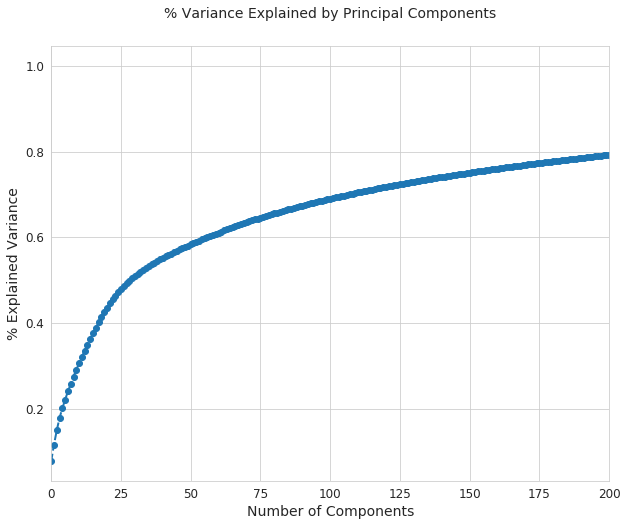

In [48]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [49]:
pca=PCA(n_components=215,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 215 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 215 components is: 0.8016671493352625


In [50]:
X_train=X_pca_21[:32567]
Y_train=fs.iloc[:32567]['Target'].values
X_test=X_pca_21[32567:]
Y_test=fs.iloc[32567:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [51]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,215).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.8705130960788529
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27649   189    27838
True        4028   701     4729
__all__    31677   890    32567

Accuracy of the model for test data is: 0.8621960206337509
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6871    69     6940
True        1053   149     1202
__all__     7924   218     8142



Logistic Regression
Accuracy of the model for training data is: 0.8997451407866859
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25352  2486    27838
True         779  3950     4729
__all__    26131  6436    32567

Accuracy of the model for test data is: 0.8986735445836403
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6309   631     6940
True         194  1008     1202
__all__     6503  1639     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9244634138852212
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25560  2278    27838
True         182  4547     4729
__all__    25742  6825    32567

Accuracy of the model for test data is: 0.9110783591255219
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6354   586     6940
True         138  1064     1202
__all__     6492  1650     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.9049037369115976
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25468  2370    27838
True         727  4002     4729
__all__    26195  6372    32567

Accuracy of the model for test data is: 0.9014984033407025
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6329   611     6940
True         191  1011     1202
__all__     6520  1622     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9137163386249885
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25565  2273    27838
True         537  4192     4729
__all__    26102  6465    32567

Accuracy of the model for test data is: 0.9096045197740112
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6356   584     6940
True         152  1050     1202
__all__     6508  1634     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9267663585838425
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25571  2267    27838
True         118  4611     4729
__all__    25689  6878    32567

Accuracy of the model for test data is: 0.9109555391795627
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6354   586     6940
True         139  1063     1202
__all__     6493  1649     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9244941198145362
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25561  2277    27838
True         182  4547     4729
__all__    25743  6824    32567

Accuracy of the model for test data is: 0.9108327192336035
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6347   593     6940
True         133  1069     1202
__all__     6480  1662     8142



Neural Network-1
The accuracy of the model on training data is: 0.9218841158245956


Predicted  False  True  __all__
Actual                         
False      25504  2334    27838
True         210  4519     4729
__all__    25714  6853    32567

The accuracy of the model on test data is: 0.90506018177352


Predicted  False  True  __all__
Actual                         
False       6306   634     6940
True         139  1063     1202
__all__     6445  1697     8142

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [52]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [53]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.870513,701.0,27649.0,189.0,4028.0,0.006789,0.851766
LogisticRegression,0.899745,3950.0,25352.0,2486.0,779.0,0.089302,0.164728
RandomForestClassifier,0.924463,4547.0,25560.0,2278.0,182.0,0.081831,0.038486
AdaBoostClassifier,0.904904,4002.0,25468.0,2370.0,727.0,0.085135,0.153732
GradientBoostingClassifier,0.913716,4192.0,25565.0,2273.0,537.0,0.081651,0.113555
ExtraTreeClassifier,0.926766,4611.0,25571.0,2267.0,118.0,0.081435,0.024952
BaggingClassifier,0.924494,4547.0,25561.0,2277.0,182.0,0.081795,0.038486
Neural Network-1,0.921884,4519.0,25504.0,2334.0,210.0,0.083842,0.044407


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.862196,149.0,6871.0,69.0,1053.0,0.009942,0.876040,0.557009,0.250555
LogisticRegression,0.898674,1008.0,6309.0,631.0,194.0,0.090922,0.161398,0.873840,0.661457
RandomForestClassifier,0.911078,1064.0,6354.0,586.0,138.0,0.084438,0.114809,0.900377,0.706642
AdaBoostClassifier,0.901498,1011.0,6329.0,611.0,191.0,0.088040,0.158902,0.876529,0.668823
GradientBoostingClassifier,0.909605,1050.0,6356.0,584.0,152.0,0.084150,0.126456,0.894697,0.699159
ExtraTreeClassifier,0.910956,1063.0,6354.0,586.0,139.0,0.084438,0.115641,0.899961,0.706068
BaggingClassifier,0.910833,1069.0,6347.0,593.0,133.0,0.085447,0.110649,0.901952,0.707511
Neural Network-1,0.905060,1063.0,6306.0,634.0,139.0,0.091354,0.115641,0.896502,0.692557


In [54]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')